In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import Image, display

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import (layers, models, callbacks, utils, datasets, losses, metrics, optimizers)
from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-23 15:00:02.696520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 15:00:02.696587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

In [2]:
train_data = utils.image_dataset_from_directory(
    "CelebA/img_align_celeba", labels=None, color_mode="rgb", image_size=(64,64), batch_size=128,
    shuffle=True, seed=42, interpolation="bilinear",)

def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x : preprocess(x))
#train_sample = sample_batch(train)
#display(train_sample, cmap="None")

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Found 202599 files belonging to 1 classes.


2024-03-23 15:00:12.620545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 15:00:12.804719: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 15:00:12.804785: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 15:00:12.807608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 15:00:12.807662: I external/local_xla/xla/stream_executor

In [3]:
encoder_input = layers.Input(shape=(64,64,3), name="encoder_input")
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(units=400, name="z_mean")(x)
z_log_var = layers.Dense(units=400, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder_output")
encoder.summary()

decoder_input = layers.Input(shape=(400,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation="sigmoid", padding="same")(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()


Model: "encoder_output"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 128)          3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)          0         ['batch_normaliza

In [4]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super (VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, 
                self.reconstruction_loss_tracker, 
                self.kl_loss_tracker,]
    
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(2000 * losses.mean_squared_error(data, reconstruction))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1,))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss":self.total_loss_tracker.result(),
            "reconstruction_loss" : self.reconstruction_loss_tracker.result(),
            "kl_loss":self.kl_loss_tracker.result(),
        }
        
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            2000 * losses.mean_squared_error(data, reconstruction))
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1,))
        total_loss = reconstruction_loss + kl_loss
        return {"loss":total_loss,
               "reconstruction_loss":reconstruction_loss,
               "kl_loss":kl_loss}

In [5]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_image = self.model.decoder(random_latent_vectors)
        generated_image *= 255
        generated_image.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_image[i])
            #img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [7]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint", save_weights_only=False, save_freq="epoch", monitor="loss", mode="min", save_best_only=True, verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

if False:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))
    
vae.fit(train, epochs=1000, steps_per_epoch=1, callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=5, latent_dim=400)],)

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 85.6695 - reconstruction_loss: 69.5082 - kl_loss: 16.1613WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 9s 9s/step - loss: 85.6695 - reconstruction_loss: 69.5082 - kl_loss: 16.1613
Epoch 2/1000
1/1 [==============================] - 0s 307ms/step - loss: 102.6511 - reconstruction_loss: 84.8350 - kl_loss: 17.8161
Epoch 3/1000
1/1 [==============================] - 0s 310ms/step - loss: 91.2608 - reconstruction_loss: 73.5077 - kl_loss: 17.7531
Epoch 4/1000
1/1 [==============================] - 0s 321ms/step - loss: 99.0663 - reconstruction_loss: 79.5312 - kl_loss: 19.5350
Epoch 5/1000
1/1 [==============================] - 0s 312ms/step - loss: 94.4766 - reconstruction_loss: 74.2764 - kl_loss: 20.2002
Epoch 6/1000
1/1 [==============================] - 0s 308ms/step - loss: 97.9518 - reconstruction_loss: 80.0057 - kl_loss: 17.9461
Epoch 7/1000
1/1 [==============================] - 0s 313ms/step - loss: 90.4237 - reconstruction_loss: 73.1400 - kl_loss: 17.2837
Epoch 8/1000
1/1 [==============================] - 0s 310ms/step - loss: 92.8662 - reconst

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 84.3710 - reconstruction_loss: 68.4133 - kl_loss: 15.9577
Epoch 22/1000
1/1 [==============================] - 0s 398ms/step - loss: 87.9113 - reconstruction_loss: 70.3805 - kl_loss: 17.5308
Epoch 23/1000
1/1 [==============================] - 0s 304ms/step - loss: 90.1604 - reconstruction_loss: 72.7948 - kl_loss: 17.3656
Epoch 24/1000
1/1 [==============================] - 0s 318ms/step - loss: 93.5798 - reconstruction_loss: 76.3255 - kl_loss: 17.2544
Epoch 25/1000
1/1 [==============================] - 0s 316ms/step - loss: 94.3712 - reconstruction_loss: 77.5459 - kl_loss: 16.8254
Epoch 26/1000
1/1 [==============================] - 0s 310ms/step - loss: 86.5121 - reconstruction_loss: 70.5997 - kl_loss: 15.9124
Epoch 27/1000
1/1 [==============================] - 0s 310ms/step - loss: 90.1417 - reconstruction_loss: 74.0601 - kl_loss: 16.0817
Epoch 28/1000
1/1 [==============================] - 0s 309ms/step - loss: 87.0961 - r

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 83.9320 - reconstruction_loss: 68.3574 - kl_loss: 15.5746
Epoch 33/1000
1/1 [==============================] - 0s 464ms/step - loss: 85.6538 - reconstruction_loss: 69.2483 - kl_loss: 16.4055
Epoch 34/1000
1/1 [==============================] - 0s 309ms/step - loss: 87.4948 - reconstruction_loss: 72.2928 - kl_loss: 15.2020
Epoch 35/1000
1/1 [==============================] - 0s 307ms/step - loss: 95.6119 - reconstruction_loss: 79.3272 - kl_loss: 16.2847
Epoch 36/1000
1/1 [==============================] - 0s 309ms/step - loss: 87.5833 - reconstruction_loss: 71.7998 - kl_loss: 15.7834
Epoch 37/1000
1/1 [==============================] - 0s 312ms/step - loss: 88.1973 - reconstruction_loss: 71.8901 - kl_loss: 16.3072
Epoch 38/1000
1/1 [==============================] - 0s 309ms/step - loss: 89.5491 - reconstruction_loss: 72.7508 - kl_loss: 16.7983
Epoch 39/1000
1/1 [==============================] - ETA: 0s - loss: 83.0351 - reconst

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 3s 3s/step - loss: 83.0351 - reconstruction_loss: 67.0030 - kl_loss: 16.0322
Epoch 40/1000
1/1 [==============================] - 0s 470ms/step - loss: 88.7114 - reconstruction_loss: 72.2062 - kl_loss: 16.5052
Epoch 41/1000
1/1 [==============================] - 0s 312ms/step - loss: 90.9421 - reconstruction_loss: 74.5894 - kl_loss: 16.3527
Epoch 42/1000
1/1 [==============================] - 0s 333ms/step - loss: 84.0712 - reconstruction_loss: 68.3742 - kl_loss: 15.6971
Epoch 43/1000
1/1 [==============================] - 0s 304ms/step - loss: 87.8488 - reconstruction_loss: 71.3126 - kl_loss: 16.5363
Epoch 44/1000
1/1 [==============================] - 0s 309ms/step - loss: 87.1290 - reconstruction_loss: 69.8502 - kl_loss: 17.2788
Epoch 45/1000
1/1 [==============================] - 0s 318ms/step - loss: 94.8172 - reconstruction_loss: 77.2058 - kl_loss: 17.6114
Epoch 46/1000
1/1 [==============================] - 0s 322ms/step - loss: 90.2710 - r

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 3s 3s/step - loss: 82.6556 - reconstruction_loss: 67.3798 - kl_loss: 15.2759
Epoch 68/1000
1/1 [==============================] - 0s 420ms/step - loss: 85.5800 - reconstruction_loss: 70.3611 - kl_loss: 15.2189
Epoch 69/1000
1/1 [==============================] - 0s 305ms/step - loss: 88.9734 - reconstruction_loss: 72.7515 - kl_loss: 16.2219
Epoch 70/1000
1/1 [==============================] - 0s 310ms/step - loss: 91.9454 - reconstruction_loss: 74.1465 - kl_loss: 17.7988
Epoch 71/1000
1/1 [==============================] - 0s 321ms/step - loss: 90.7580 - reconstruction_loss: 73.1545 - kl_loss: 17.6034
Epoch 72/1000
1/1 [==============================] - 0s 318ms/step - loss: 88.3280 - reconstruction_loss: 71.0513 - kl_loss: 17.2767
Epoch 73/1000
1/1 [==============================] - 0s 310ms/step - loss: 93.4213 - reconstruction_loss: 76.8493 - kl_loss: 16.5719
Epoch 74/1000
1/1 [==============================] - 0s 312ms/step - loss: 85.4826 - r

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 81.9896 - reconstruction_loss: 65.6170 - kl_loss: 16.3727
Epoch 80/1000
1/1 [==============================] - 0s 461ms/step - loss: 85.2826 - reconstruction_loss: 69.7532 - kl_loss: 15.5294
Epoch 81/1000
1/1 [==============================] - 0s 328ms/step - loss: 91.2767 - reconstruction_loss: 75.4681 - kl_loss: 15.8086
Epoch 82/1000
1/1 [==============================] - 0s 305ms/step - loss: 84.8353 - reconstruction_loss: 69.0596 - kl_loss: 15.7756
Epoch 83/1000
1/1 [==============================] - 0s 308ms/step - loss: 87.4056 - reconstruction_loss: 72.1364 - kl_loss: 15.2692
Epoch 84/1000
1/1 [==============================] - 0s 313ms/step - loss: 91.3045 - reconstruction_loss: 74.9795 - kl_loss: 16.3250
Epoch 85/1000
1/1 [==============================] - 0s 308ms/step - loss: 90.2956 - reconstruction_loss: 73.4102 - kl_loss: 16.8854
Epoch 86/1000
1/1 [==============================] - 0s 308ms/step - loss: 89.6830 - r

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 3s 3s/step - loss: 80.4091 - reconstruction_loss: 65.2641 - kl_loss: 15.1450
Epoch 105/1000
1/1 [==============================] - 0s 422ms/step - loss: 84.3914 - reconstruction_loss: 69.7651 - kl_loss: 14.6263
Epoch 106/1000
1/1 [==============================] - 0s 304ms/step - loss: 89.7646 - reconstruction_loss: 74.4052 - kl_loss: 15.3594
Epoch 107/1000
1/1 [==============================] - 0s 305ms/step - loss: 93.6335 - reconstruction_loss: 77.9138 - kl_loss: 15.7197
Epoch 108/1000
1/1 [==============================] - 0s 315ms/step - loss: 89.3059 - reconstruction_loss: 71.5860 - kl_loss: 17.7199
Epoch 109/1000
1/1 [==============================] - 0s 308ms/step - loss: 89.7314 - reconstruction_loss: 72.5014 - kl_loss: 17.2300
Epoch 110/1000
1/1 [==============================] - 0s 308ms/step - loss: 89.3289 - reconstruction_loss: 71.5015 - kl_loss: 17.8274
Epoch 111/1000
1/1 [==============================] - 0s 309ms/step - loss: 88.3

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 80.1873 - reconstruction_loss: 64.9648 - kl_loss: 15.2225
Epoch 225/1000
1/1 [==============================] - 0s 459ms/step - loss: 88.0696 - reconstruction_loss: 72.5530 - kl_loss: 15.5166
Epoch 226/1000
1/1 [==============================] - 0s 307ms/step - loss: 86.4971 - reconstruction_loss: 71.1984 - kl_loss: 15.2987
Epoch 227/1000
1/1 [==============================] - 0s 320ms/step - loss: 83.0506 - reconstruction_loss: 67.6570 - kl_loss: 15.3935
Epoch 228/1000
1/1 [==============================] - 0s 307ms/step - loss: 85.7861 - reconstruction_loss: 70.4124 - kl_loss: 15.3737
Epoch 229/1000
1/1 [==============================] - 0s 308ms/step - loss: 85.5861 - reconstruction_loss: 69.1991 - kl_loss: 16.3870
Epoch 230/1000
1/1 [==============================] - 0s 320ms/step - loss: 86.2327 - reconstruction_loss: 69.1980 - kl_loss: 17.0347
Epoch 231/1000
1/1 [==============================] - 0s 312ms/step - loss: 85.7

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 3s 3s/step - loss: 79.7958 - reconstruction_loss: 64.8457 - kl_loss: 14.9501
Epoch 267/1000
1/1 [==============================] - 0s 447ms/step - loss: 87.0131 - reconstruction_loss: 70.4540 - kl_loss: 16.5591
Epoch 268/1000
1/1 [==============================] - 0s 310ms/step - loss: 85.3318 - reconstruction_loss: 70.2752 - kl_loss: 15.0567
Epoch 269/1000
1/1 [==============================] - 0s 312ms/step - loss: 83.1844 - reconstruction_loss: 66.8013 - kl_loss: 16.3831
Epoch 270/1000
1/1 [==============================] - 0s 322ms/step - loss: 85.2802 - reconstruction_loss: 68.9176 - kl_loss: 16.3626
Epoch 271/1000
1/1 [==============================] - 0s 317ms/step - loss: 85.8962 - reconstruction_loss: 67.9772 - kl_loss: 17.9190
Epoch 272/1000
1/1 [==============================] - 0s 314ms/step - loss: 81.7338 - reconstruction_loss: 64.1691 - kl_loss: 17.5647
Epoch 273/1000
1/1 [==============================] - 0s 319ms/step - loss: 84.6

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 3s 3s/step - loss: 76.2714 - reconstruction_loss: 61.8624 - kl_loss: 14.4091
Epoch 326/1000
1/1 [==============================] - 0s 463ms/step - loss: 81.2643 - reconstruction_loss: 65.8103 - kl_loss: 15.4540
Epoch 327/1000
1/1 [==============================] - 0s 308ms/step - loss: 82.5541 - reconstruction_loss: 66.8609 - kl_loss: 15.6932
Epoch 328/1000
1/1 [==============================] - 0s 309ms/step - loss: 86.6179 - reconstruction_loss: 70.7000 - kl_loss: 15.9179
Epoch 329/1000
1/1 [==============================] - 0s 317ms/step - loss: 82.5761 - reconstruction_loss: 66.8518 - kl_loss: 15.7243
Epoch 330/1000
1/1 [==============================] - 0s 316ms/step - loss: 81.9134 - reconstruction_loss: 66.8435 - kl_loss: 15.0698
Epoch 331/1000
1/1 [==============================] - 0s 312ms/step - loss: 80.6362 - reconstruction_loss: 64.2109 - kl_loss: 16.4253
Epoch 332/1000
1/1 [==============================] - 0s 313ms/step - loss: 83.1

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 74.8940 - reconstruction_loss: 60.8516 - kl_loss: 14.0424
Epoch 399/1000
1/1 [==============================] - 0s 434ms/step - loss: 79.2930 - reconstruction_loss: 64.2454 - kl_loss: 15.0475
Epoch 400/1000
1/1 [==============================] - 0s 307ms/step - loss: 77.2883 - reconstruction_loss: 62.8937 - kl_loss: 14.3946
Epoch 401/1000
1/1 [==============================] - 0s 320ms/step - loss: 82.7054 - reconstruction_loss: 67.4378 - kl_loss: 15.2676
Epoch 402/1000
1/1 [==============================] - 0s 330ms/step - loss: 79.3043 - reconstruction_loss: 63.1652 - kl_loss: 16.1390
Epoch 403/1000
1/1 [==============================] - 0s 319ms/step - loss: 82.8043 - reconstruction_loss: 66.4523 - kl_loss: 16.3520
Epoch 404/1000
1/1 [==============================] - 0s 312ms/step - loss: 80.7456 - reconstruction_loss: 63.7820 - kl_loss: 16.9636
Epoch 405/1000
1/1 [==============================] - 0s 316ms/step - loss: 77.9

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 73.3957 - reconstruction_loss: 59.9858 - kl_loss: 13.4099
Epoch 411/1000
1/1 [==============================] - 0s 484ms/step - loss: 79.0505 - reconstruction_loss: 64.4174 - kl_loss: 14.6331
Epoch 412/1000
1/1 [==============================] - 0s 309ms/step - loss: 84.3533 - reconstruction_loss: 68.9830 - kl_loss: 15.3703
Epoch 413/1000
1/1 [==============================] - 0s 314ms/step - loss: 77.9800 - reconstruction_loss: 63.8842 - kl_loss: 14.0958
Epoch 414/1000
1/1 [==============================] - 0s 337ms/step - loss: 81.5753 - reconstruction_loss: 66.3970 - kl_loss: 15.1783
Epoch 415/1000
1/1 [==============================] - 0s 309ms/step - loss: 82.9846 - reconstruction_loss: 66.9145 - kl_loss: 16.0701
Epoch 416/1000
1/1 [==============================] - 0s 309ms/step - loss: 83.8833 - reconstruction_loss: 66.9265 - kl_loss: 16.9568
Epoch 417/1000
1/1 [==============================] - 0s 320ms/step - loss: 78.2

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 70.8681 - reconstruction_loss: 55.7749 - kl_loss: 15.0932
Epoch 583/1000
1/1 [==============================] - 0s 484ms/step - loss: 77.4597 - reconstruction_loss: 61.9558 - kl_loss: 15.5039
Epoch 584/1000
1/1 [==============================] - 0s 333ms/step - loss: 78.1319 - reconstruction_loss: 62.0664 - kl_loss: 16.0655
Epoch 585/1000
1/1 [==============================] - 0s 313ms/step - loss: 76.7173 - reconstruction_loss: 61.9536 - kl_loss: 14.7637
Epoch 586/1000
1/1 [==============================] - 0s 311ms/step - loss: 75.1409 - reconstruction_loss: 60.1266 - kl_loss: 15.0142
Epoch 587/1000
1/1 [==============================] - 0s 318ms/step - loss: 78.4820 - reconstruction_loss: 63.0223 - kl_loss: 15.4597
Epoch 588/1000
1/1 [==============================] - 0s 312ms/step - loss: 76.7290 - reconstruction_loss: 61.2532 - kl_loss: 15.4758
Epoch 589/1000
1/1 [==============================] - 0s 327ms/step - loss: 76.3

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 3s 3s/step - loss: 69.3919 - reconstruction_loss: 54.7506 - kl_loss: 14.6413
Epoch 663/1000
1/1 [==============================] - 0s 465ms/step - loss: 75.5876 - reconstruction_loss: 59.8129 - kl_loss: 15.7747
Epoch 664/1000
1/1 [==============================] - 0s 308ms/step - loss: 76.7527 - reconstruction_loss: 60.9816 - kl_loss: 15.7711
Epoch 665/1000
1/1 [==============================] - 0s 308ms/step - loss: 79.7341 - reconstruction_loss: 64.2302 - kl_loss: 15.5039
Epoch 666/1000
1/1 [==============================] - 0s 316ms/step - loss: 74.5508 - reconstruction_loss: 59.0591 - kl_loss: 15.4917
Epoch 667/1000
1/1 [==============================] - 0s 315ms/step - loss: 71.7824 - reconstruction_loss: 57.5642 - kl_loss: 14.2182
Epoch 668/1000
1/1 [==============================] - 0s 312ms/step - loss: 74.3382 - reconstruction_loss: 59.7240 - kl_loss: 14.6142
Epoch 669/1000
1/1 [==============================] - 0s 312ms/step - loss: 78.5

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 3s 3s/step - loss: 68.6502 - reconstruction_loss: 54.5630 - kl_loss: 14.0872
Epoch 698/1000
1/1 [==============================] - 0s 457ms/step - loss: 73.9424 - reconstruction_loss: 58.9406 - kl_loss: 15.0019
Epoch 699/1000
1/1 [==============================] - 0s 309ms/step - loss: 77.6960 - reconstruction_loss: 62.1658 - kl_loss: 15.5301
Epoch 700/1000
1/1 [==============================] - 0s 319ms/step - loss: 76.6424 - reconstruction_loss: 60.7240 - kl_loss: 15.9184
Epoch 701/1000
1/1 [==============================] - 0s 320ms/step - loss: 75.7443 - reconstruction_loss: 60.6494 - kl_loss: 15.0948
Epoch 702/1000
1/1 [==============================] - 0s 307ms/step - loss: 77.7724 - reconstruction_loss: 62.1814 - kl_loss: 15.5909
Epoch 703/1000
1/1 [==============================] - 0s 316ms/step - loss: 71.3456 - reconstruction_loss: 56.1775 - kl_loss: 15.1680
Epoch 704/1000
1/1 [==============================] - 0s 319ms/step - loss: 73.3

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 3s 3s/step - loss: 68.2208 - reconstruction_loss: 53.7657 - kl_loss: 14.4552
Epoch 712/1000
1/1 [==============================] - 0s 443ms/step - loss: 74.9601 - reconstruction_loss: 58.8765 - kl_loss: 16.0836
Epoch 713/1000
1/1 [==============================] - 0s 306ms/step - loss: 73.2843 - reconstruction_loss: 58.2822 - kl_loss: 15.0022
Epoch 714/1000
1/1 [==============================] - 0s 315ms/step - loss: 75.1441 - reconstruction_loss: 59.9138 - kl_loss: 15.2303
Epoch 715/1000
1/1 [==============================] - 0s 309ms/step - loss: 77.0070 - reconstruction_loss: 61.5070 - kl_loss: 15.5000
Epoch 716/1000
1/1 [==============================] - 0s 313ms/step - loss: 71.0327 - reconstruction_loss: 56.6309 - kl_loss: 14.4018
Epoch 717/1000
1/1 [==============================] - 0s 311ms/step - loss: 73.4169 - reconstruction_loss: 58.6114 - kl_loss: 14.8056
Epoch 718/1000
1/1 [==============================] - 0s 320ms/step - loss: 74.9

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 68.1612 - reconstruction_loss: 53.1078 - kl_loss: 15.0534
Epoch 791/1000
1/1 [==============================] - 0s 477ms/step - loss: 75.8827 - reconstruction_loss: 60.2568 - kl_loss: 15.6259
Epoch 792/1000
1/1 [==============================] - 0s 306ms/step - loss: 74.4254 - reconstruction_loss: 58.3125 - kl_loss: 16.1129
Epoch 793/1000
1/1 [==============================] - 0s 306ms/step - loss: 74.9933 - reconstruction_loss: 59.0172 - kl_loss: 15.9760
Epoch 794/1000
1/1 [==============================] - 0s 320ms/step - loss: 74.6237 - reconstruction_loss: 58.9880 - kl_loss: 15.6356
Epoch 795/1000
1/1 [==============================] - 0s 316ms/step - loss: 73.2424 - reconstruction_loss: 58.5474 - kl_loss: 14.6950
Epoch 796/1000
1/1 [==============================] - 0s 308ms/step - loss: 78.4369 - reconstruction_loss: 63.1505 - kl_loss: 15.2864
Epoch 797/1000
1/1 [==============================] - 0s 332ms/step - loss: 72.6

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 67.9407 - reconstruction_loss: 53.2221 - kl_loss: 14.7187
Epoch 949/1000
1/1 [==============================] - 0s 469ms/step - loss: 72.7133 - reconstruction_loss: 56.6216 - kl_loss: 16.0917
Epoch 950/1000
1/1 [==============================] - 0s 306ms/step - loss: 74.3723 - reconstruction_loss: 58.2853 - kl_loss: 16.0870
Epoch 951/1000
1/1 [==============================] - 0s 305ms/step - loss: 75.3852 - reconstruction_loss: 60.1444 - kl_loss: 15.2408
Epoch 952/1000
1/1 [==============================] - 0s 320ms/step - loss: 70.8318 - reconstruction_loss: 55.4280 - kl_loss: 15.4038
Epoch 953/1000
1/1 [==============================] - 0s 320ms/step - loss: 72.3000 - reconstruction_loss: 57.6162 - kl_loss: 14.6838
Epoch 954/1000
1/1 [==============================] - 0s 307ms/step - loss: 73.7173 - reconstruction_loss: 59.1616 - kl_loss: 14.5557
Epoch 955/1000
1/1 [==============================] - 0s 310ms/step - loss: 72.8

In [8]:
vae.save("./models/vae_celeba")
encoder.save("./models/vae_celeba_encoder")
decoder.save("./models/vae_celeba_decoder")

INFO:tensorflow:Assets written to: ./models/vae_celeba/assets


INFO:tensorflow:Assets written to: ./models/vae_celeba/assets


INFO:tensorflow:Assets written to: ./models/vae_celeba_encoder/assets


INFO:tensorflow:Assets written to: ./models/vae_celeba_encoder/assets


INFO:tensorflow:Assets written to: ./models/vae_celeba_decoder/assets


INFO:tensorflow:Assets written to: ./models/vae_celeba_decoder/assets


In [9]:
batches_to_predict = 1
example_images = np.array(list(train.take(batches_to_predict).get_single_element()))

z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("example images")
display(example_images)
print("Reconstructions")
display(reconstructions)

4/4 [==============================] - 2s 17ms/step
example images


array([[[[0.99215686, 0.99607843, 0.9764706 ],
         [0.99215686, 0.99607843, 0.9764706 ],
         [0.99215686, 0.99607843, 0.9764706 ],
         ...,
         [0.9607843 , 0.9764706 , 0.972549  ],
         [0.9607843 , 0.9764706 , 0.972549  ],
         [0.9607843 , 0.9764706 , 0.972549  ]],

        [[0.99215686, 0.99607843, 0.9764706 ],
         [0.99215686, 0.99607843, 0.9764706 ],
         [0.99215686, 0.99607843, 0.9764706 ],
         ...,
         [0.9607843 , 0.9764706 , 0.972549  ],
         [0.9607843 , 0.9764706 , 0.972549  ],
         [0.9607843 , 0.9764706 , 0.972549  ]],

        [[0.99215686, 0.99607843, 0.9764706 ],
         [0.99215686, 0.99607843, 0.9764706 ],
         [0.99215686, 0.99607843, 0.9764706 ],
         ...,
         [0.9607843 , 0.9764706 , 0.972549  ],
         [0.9607843 , 0.9764706 , 0.972549  ],
         [0.9607843 , 0.9764706 , 0.972549  ]],

        ...,

        [[0.17120098, 0.12022059, 0.3005036 ],
         [0.1748784 , 0.12389801, 0.29898036]

Reconstructions


array([[[[0.9394838 , 0.9362484 , 0.9436293 ],
         [0.94604284, 0.9482638 , 0.9490679 ],
         [0.95294356, 0.95601654, 0.9593933 ],
         ...,
         [0.96190643, 0.96486324, 0.9610143 ],
         [0.9573384 , 0.96308833, 0.96032196],
         [0.9274432 , 0.9369153 , 0.93689257]],

        [[0.94607717, 0.9497595 , 0.9526143 ],
         [0.95047766, 0.94919044, 0.95790994],
         [0.9537961 , 0.9625022 , 0.963942  ],
         ...,
         [0.96576613, 0.96529603, 0.96719956],
         [0.9602482 , 0.96866167, 0.9641894 ],
         [0.94562584, 0.94776285, 0.946923  ]],

        [[0.9499022 , 0.9550292 , 0.95940065],
         [0.95274425, 0.95942307, 0.9628346 ],
         [0.96009785, 0.9621674 , 0.97017395],
         ...,
         [0.9647391 , 0.97522175, 0.9670907 ],
         [0.96469516, 0.9736111 , 0.9708228 ],
         [0.95123243, 0.95838034, 0.9565523 ]],

        ...,

        [[0.19725448, 0.17206623, 0.16147704],
         [0.18372212, 0.15041092, 0.13549167]

4/4 [==============================] - 0s 46ms/step


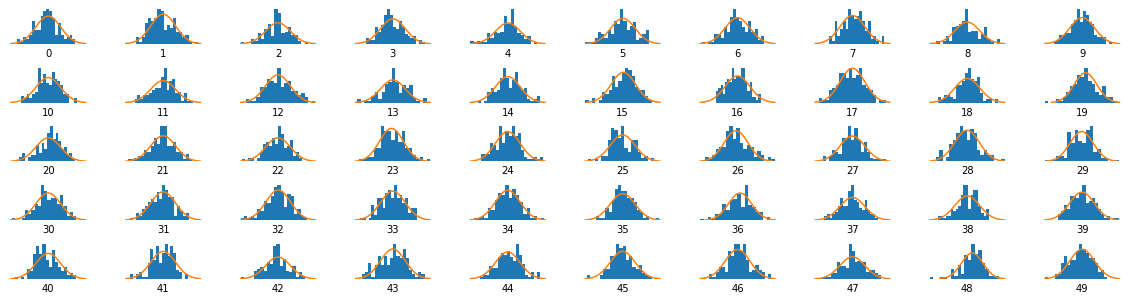

1/1 [==============================] - 1s 1s/step


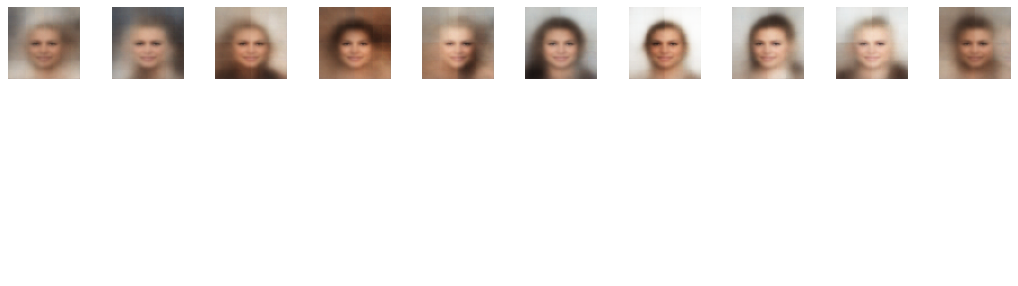

In [10]:
#latent space distribution

_, _, z = vae.encoder.predict(example_images)
x = np.linspace(-3, 3, 100)
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z[:,i], density=True, bins=20)
    ax.axis("off")
    ax.text(0.5, -0.35, str(i), fontsize=10, ha="center", transform = ax.transAxes)
    ax.plot(x, norm.pdf(x))
plt.show()

grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width, 400))
reconstructions = decoder.predict(z_sample)
num_samples = reconstructions.shape[0]
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    if i < num_samples:
        ax.imshow(reconstructions[i, :, :])
plt.show()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
Found 202599 files belonging to 2 classes.
Using 40519 files for validation.
label: Bangs
images : POS move : NEG move :distance : 𝛥 distance
23    : 4.67    : 2.166    : 4.954    : 4.954
53    : 3.165    : 1.377    : 3.345    : -1.609
71    : 1.426    : 0.848    : 2.927    : -0.418
90    : 1.071    : 0.559   

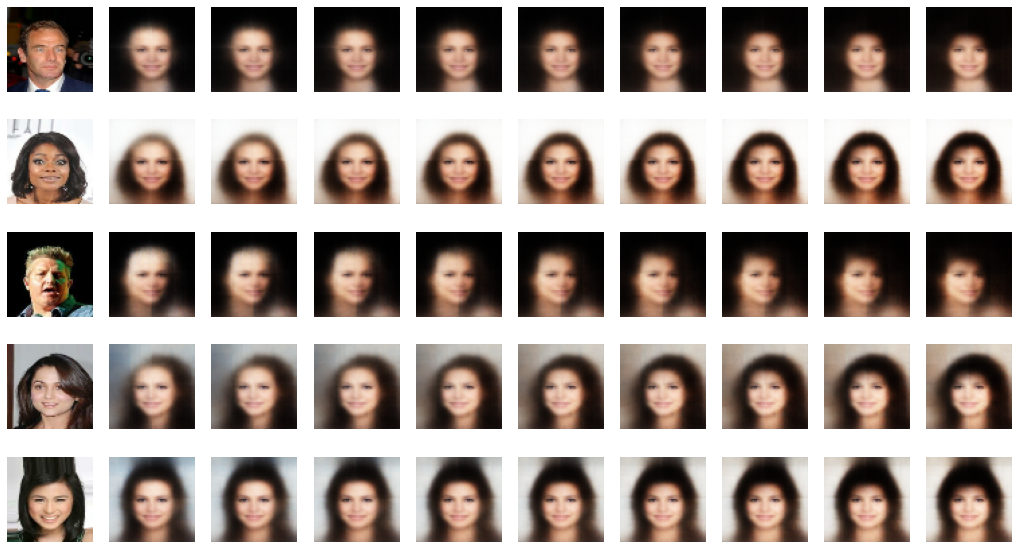

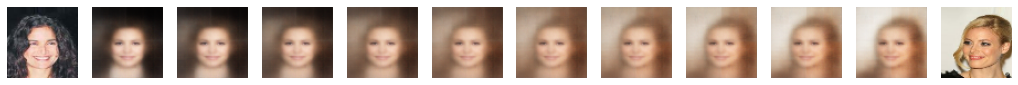

In [11]:
#Manipulate the Images

attributes = pd.read_csv("CelebA/Anno/Anno/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

label = "Bangs"
labelled_test = utils.image_dataset_from_directory(
    "CelebA/img_align_celeba", color_mode="rgb", image_size=(64,64), batch_size=128,
    shuffle=True, seed=42, validation_split=0.2, subset="validation", interpolation="bilinear",labels=attributes[label].tolist()
)
labelled = labelled_test.map(lambda x, y : (preprocess(x), y))
attribute_vec = get_vector_from_label(labelled, vae, 400, label)
add_vector_to_images(labelled, vae, attribute_vec)
morph_faces(labelled, vae)

In [15]:
vae.history.history.keys()

dict_keys([])